In [354]:
import sys
sys.path.append('../')

import gc
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats

#from sa_decomp_layer import SADecompLayer



import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet152, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp
from glob import glob


from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE
from imagenet_utils.imagenet_clsloc2 import clsloc
from imagenet_utils.load_images import load_images
from imagenet_utils.preprocess import preprocess

from utils.utils import *

import keras
from keras import layers

from keras import backend as K

import scienceplots

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [355]:
gc.collect()
model = VGG16(weights='imagenet',
				  include_top=True,
				  input_shape=(224, 224, 3))

model.layers[-1].activation = None  #keras.activations.relu



In [356]:
def kernel_grads(input_img, model_original, l_num, pred_idx=None)  :
	# First, we create a model that maps the input image to the activations
	# of the last conv layer as well as the output predictions
	model = tf.keras.models.clone_model(model_original)
	model.set_weights(model_original.get_weights())
	conv_layers = []
	for l in model.layers:
		try:
			l.use_bias = True
		except:
			continue

		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3):
				
				conv_layers.append(l)
				
				#print(l.kernel_regularizer)

	#last_conv_layer_name = conv_layers[l_num].name
	layer_num = model.layers.index(conv_layers[l_num])
	layer_num_p = layer_num-1

	print(model.layers[layer_num].name)

	print(model.layers[layer_num-1].name)

	#second_last_conv_layer_name = conv_layers[l_num-1].name

	grad_model = keras.models.Model(
		model.inputs, [model.layers[layer_num_p].output, model.layers[layer_num].output, model.output]
	)
	'''first_half = keras.models.Model(
		model.inputs, [model.layers[layer_num-1].output]
	)

	second_half = keras.models.Model(
		tf.keras.Input(tensor=model.layers[layer_num+1].input), [model.output]
	)

	#grad_model.get_layer(last_conv_layer_name).use_bias=False
	#grad_model.get_layer(second_last_conv_layer_name).use_bias=False
	model.layers[layer_num].activation = None'''

	with tf.GradientTape(persistent=True) as tape:
		second_last_conv_layer_output, last_conv_layer_output, preds = grad_model(input_img, training=False)

		'''activation1 =  first_half(input_img, training=False)
		act2_pre_relu = model.layers[layer_num](activation1)
		#tape.watch(act2_pre_relu)
		act2_post_relu = tf.nn.relu(act2_pre_relu)
		#tape.watch(act2_post_relu)

		preds = second_half(act2_post_relu, training=False)'''
		if pred_idx is None:
			pred_idx = tf.argmax(preds[0])
		print(tf.argmax(preds[0]))
		print(decode_predictions(preds.numpy()))
		class_channel = preds[:, pred_idx]
	print("GRAD M ", grad_model.layers[layer_num].name)
	gradsW = tape.gradient(class_channel,  grad_model.layers[layer_num].trainable_variables)[0] #

	print(model.layers[layer_num].trainable_variables[0].shape)
	grads_last = tape.gradient(class_channel,  last_conv_layer_output) #
	grads2ndlast = tape.gradient(class_channel,  second_last_conv_layer_output) #

	#print(grads)
	
	'''last_pooled_grads = tf.reduce_mean(tape.gradient(class_channel,  last_conv_layer_output), axis=(0, 1, 2))
	second_last_pooled_grads = tf.reduce_mean(tape.gradient(class_channel,  second_last_conv_layer_output), axis=(0, 1, 2))'''

	#print(pooled_grads)

	#print("LAST FEATURE : ", last_conv_layer_output.shape)
	#top_k_filters = tf.math.top_k(pooled_grads, k=10).indices 
	#bottom_k_filters = tf.math.top_k(-pooled_grads, k=10).indices 
	

	return  grads2ndlast, grads_last, gradsW , second_last_conv_layer_output,last_conv_layer_output  # second_last_pooled_grads,last_pooled_grads , second_last_conv_layer_output.numpy(), last_conv_layer_output.numpy() #, bottom_k_filters, last_conv_layer_output.numpy()


In [357]:
# Imagenet Validation Set location
img = "C:/ILSVRC2012_img_val/ILSVRC2012_val_00000028.JPEG"

In [358]:
train_list = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in train_labels], num_classes = 1000)


trainDS = Dataset.from_tensor_slices((train_list, train_labels))
trainDS = (trainDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(1)
	.prefetch(AUTOTUNE)
)


val_list = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in val_list], num_classes = 1000)


valDS = Dataset.from_tensor_slices((val_list, val_labels))
valDS = (valDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(1)
	.prefetch(AUTOTUNE)
)

In [359]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img, dtype="uint8")
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [360]:
l_num  = -1

In [361]:
len(val_list)


3925

In [362]:
np.argmax(val_labels[num])

217

217
C:/imagenette2/val\n02102040\ILSVRC2012_val_00025442.JPEG
block5_conv3
block5_conv2
tf.Tensor(217, shape=(), dtype=int64)
[[('n02102040', 'English_springer', 18.015596), ('n02101388', 'Brittany_spaniel', 12.764867), ('n02102318', 'cocker_spaniel', 12.164763), ('n02102177', 'Welsh_springer_spaniel', 12.143085), ('n02102480', 'Sussex_spaniel', 12.07066)]]
GRAD M  block5_conv3
(3, 3, 512, 512)


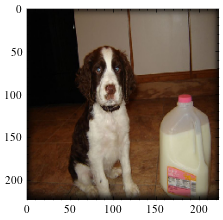

In [363]:
gc.collect()

num = 396

original_img = get_img_array(val_list[num], size=(224,224))
img = keras.applications.vgg16.preprocess_input(original_img)

plt.imshow(original_img[0])
print(np.argmax(val_labels[num]))
print(val_list[num])

g2,g1,gw,f2,f1  = kernel_grads(img, model, l_num,  pred_idx= np.argmax(val_labels[num]))
#feature.shape
#g   #[0,:,:, 0]

In [364]:
topFilters = tf.math.top_k(tf.math.reduce_mean(g1, axis=(0,1,2)), k=10)
print(topFilters)
tf.transpose(tf.math.top_k(tf.transpose(tf.reduce_mean(gw, axis=(0,1))), k=10).indices).numpy()[:, topFilters.indices.numpy()]

TopKV2(values=<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.00163194, 0.00050207, 0.00041255, 0.00031918, 0.0003186 ,
       0.00031691, 0.0002899 , 0.00026453, 0.00025019, 0.00024984],
      dtype=float32)>, indices=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([155, 441, 141, 370, 158, 364, 180, 485,   8, 113])>)


array([[376, 178, 281, 374, 374, 376, 376, 374, 374, 427],
       [374, 427, 384, 376, 376, 374, 374, 192, 192, 109],
       [384, 431, 410, 192, 192, 192, 192, 376, 238, 431],
       [192, 109, 438, 438, 438, 238, 238, 384, 441, 262],
       [410, 262, 376, 410, 384, 441, 441, 441, 376, 405],
       [377, 355, 497, 281, 281, 438, 281, 238, 384, 191],
       [441, 498, 178, 441, 410,  38, 384, 281,  38, 304],
       [281, 424, 374, 384, 441, 384, 438, 438, 443, 425],
       [238, 405, 244, 228, 238, 281, 181, 223,  22, 225],
       [405,  81, 377,  28, 228, 410, 410,  22, 348, 159]])

 ============ LAYER -1 ==================
(3, 3, 512, 512)
(512, 512)
TopKV2(values=<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.00959646, 0.00869195, 0.00761698, 0.00612597, 0.0028645 ,
       0.00274458, 0.00267474, 0.00241285, 0.0023906 , 0.00230404],
      dtype=float32)>, indices=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([155, 364, 268, 158, 485, 404, 370, 180, 111,   8])>)


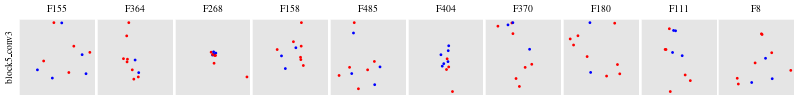

In [365]:

#plt.style.use(['ggplot'])
plt.rcParams.update({'figure.dpi': '100'})

plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []

fig= plt.figure(figsize = (10,13))
fig.clf()
#fig.tight_layout()
gs1 = gridspec.GridSpec(1, 10)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
ax = [fig.add_subplot(ss) for ss in gs1]
ax = np.reshape(ax, (1, 10))
#fig, ax = plt.subplots(gs1 , sharex=False, sharey=False)

#fig.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0)


#fig.set_tight_layout(True)
print(f" ============ LAYER {l_num} ==================")
#top10F= [155] #tf.math.top_k(lastGrads.numpy(), k=10).indices.numpy()  # topFilters.numpy()  #.indices#topKfilters(model, l_num, k=5)   #      #


#top10F = tf.math.top_k(tf.math.reduce_mean(g1[:,1:-2,1:-2,:], axis=(0,1,2)) * tf.where(tf.greater(tf.math.reduce_mean(f1, axis=(0,1,2)), 0), 1.,0.), k=5)



#print(topW[:, top10F.indices.numpy()])

#topChannels = tf.math.top_k(secondLastGrads.numpy(), k=5).indices.numpy()
#bottomChannels = tf.math.top_k(-secondLastGrads.numpy(), k=2).indices.numpy()
#bottomChannels = tf.math.top_k(-secondLastGrads.numpy(), k=5).indices.numpy()



filters = get_filter(model, l_num)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

mag = reduce_euclidean_norm(filters, axis=[0,1])
dc = np.sign(np.mean(filters, axis=(0,1)))
print(dc.shape)
#find lims :

top10F = tf.math.top_k(tf.math.reduce_mean(g1, axis=(0,1,2)) * tf.math.reduce_mean(f1, axis=(0,1,2)) , k=10)
print(top10F)
#topW = tf.transpose(tf.math.top_k(tf.transpose(tf.reduce_mean(gw, axis=(0,1))*tf.math.reduce_sum(filters**2, axis=(0,1,2))), k=20).indices).numpy()#[:, top10F.indices.numpy()]
topW = tf.transpose(tf.math.top_k(tf.transpose(tf.reduce_mean(gw, axis=(0,1))), k=10).indices).numpy()

for i,F in enumerate(top10F.indices.numpy()):  ##range(top10F.indices.numpy().shape[-1]):
	
	x =a_mag[:,F]*np.cos((theta[:,F]))
	y = a_mag[:,F]*np.sin((theta[:,F]))
	z = s_mag[:,F]*dc[:,F]
	lim_x = np.max(np.abs(x.numpy()[topW[:,F]]))
	lim_y = np.max(np.abs(y.numpy()[topW[:,F]]))
	lim_z = np.max(np.abs(z))
	lim = np.max([lim_x, lim_y])
	#lim =np.max(np.abs(mag[:, i]))    
	lim*= 1.1

	cov = np.cov([x,y])
	e_val, e_vec = np.linalg.eigh(cov)
	e_vec = e_vec[:, np.argmax(e_val)]
	e_val = np.max(e_val)
	if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
		e_vec *= -1
	#print(e_val, e_vec)

	#ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
	ax[0, i].set_xlim(-lim, lim)
	ax[0, i].set_ylim(-lim, lim)
	#ax[0, F].set_zlim(-lim, lim)


	

	color =  matplotlib.colors.Normalize(vmin=-1, vmax=1)(dc[topW[:,F], F])
	#alpha =  matplotlib.colors.Normalize()(dy_dw_mag.numpy()[:, top10F[i]])
	try:
		#ax[0, i].scatter(x[color>0.5],y[color>0.5],z[color>0.5], c=(dc[color>0.5, i]+1)/2, cmap="bwr",s=2)  
		#ax[0, i].scatter(x.numpy()[bottomChannels],y.numpy()[bottomChannels],z.numpy()[bottomChannels],  c='blue', cmap="Blues",s=.1)
		ax[0, i].scatter(x.numpy()[topW[:,F]],y.numpy()[topW[:,F]], c=color,s=1, cmap="bwr", vmin=0, vmax=1)
		#ax[0, F].scatter(x.numpy()[topChannels[155,:]],y.numpy()[topChannels[155,:]],z.numpy()[topChannels[155,:]], c='red',s=2)

	except Exception as e:
		print(e)
		#ax[0, i].scatter()  

	#ax[0, i].view_init(90,-90)
	ax[0, i].set_box_aspect(1)

	#ax[l_num, i].set_aspect('equal')
	ax[0, i].collections[0].set_rasterized(True)

	#ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
	#ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
	'''ax[l_num, i].annotate("", xy=(e_vec[0]*e_val, e_vec[1]*e_val), xytext=(0, 0), 
				arrowprops=dict(arrowstyle="->",  color='black', lw=None))'''


	'''ax[0, i].xaxis.pane.set_visible(False)
	ax[0, i].yaxis.pane.set_visible(False)
	ax[0, i].zaxis.pane.set_visible(False)'''
	#ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")

	# Remove axis labels and ticks
	ax[0, i].set_xticks([])
	ax[0, i].set_yticks([])
	#ax[0, i].set_zticks([])
	#ax[0, i].axis('off')  # Optionally hide axis lines

	#ax[0, i].set_xlabel(f"F{F}", fontsize=7,) 
	ax[0, i].set_title(f"F{F}",  fontsize=7)  # Adjust 'pad' for spacing
	#ax[0, i].dist = 5
for i in [l_num]:
	
	ax[0, 0].set_ylabel(f"{conv_layers[i].name}", fontsize=7) 
#fig.tight_layout()

#]fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)
#fig.subplots_adjust(top=1, bottom=0, left=-1, right=1) 


In [366]:
#topW = tf.transpose(tf.math.top_k(tf.transpose(tf.reduce_mean(gw, axis=(0,1))*tf.math.reduce_sum(filters**2, axis=(0,1,2))), k=20).indices).numpy()#[:, top10F.indices.numpy()]
#topW[:,196]

In [367]:
color =  matplotlib.colors.Normalize(vmin=-1, vmax=1)(-dc[topW[:,4], 4])
color

masked_array(data=[1., 1., 0., 0., 0., 1., 0., 0., 1., 1.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

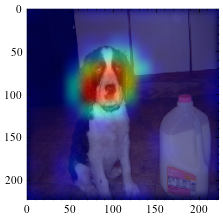

In [368]:

import matplotlib as mpl

last_conv_layer_output = f1[0]
heatmap = last_conv_layer_output @ tf.reduce_mean(g1, axis=(0, 1, 2))[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)


heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = mpl.colormaps["jet"]
# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((original_img.shape[1], original_img.shape[2]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)


superimposed_img = jet_heatmap + original_img[0]
superimposed_img = keras.utils.array_to_img(superimposed_img)

plt.imshow(superimposed_img)



In [369]:
F

8

In [370]:
topW[:,F]

array([374, 192, 238, 441, 376, 384,  38, 443,  22, 348])

(3, 3, 512, 512)
(10,)
(10,)
Above [[384]
 [178]
 [497]]
below [[376]
 [374]
 [441]]


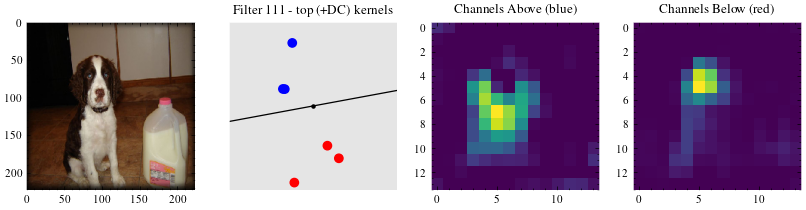

In [371]:
plt.rcParams.update({'figure.dpi': '100'})
F = 111


topW
posChannels = tf.where(tf.greater(dc[topW[:,F], F],0))[:,0].numpy()


filters = get_filter(model, l_num)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()[topW[:,F]]
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()[topW[:,F]]
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1



cov = np.cov([x,y])
e_val, e_vec = np.linalg.eigh(cov)
e_vec1 = e_vec[:, np.argmax(e_val)]
e_vec2 = e_vec[:, np.argmin(e_val)]

print(x.shape)
x =x[posChannels]
y = y[posChannels]
e_vec2
fig,ax  = plt.subplots(1,4,figsize=(10,3))

ax[0].imshow(original_img[0])




ax[1].scatter(x,y, c=np.sign((x * e_vec2[1]/e_vec2[0])-y), cmap = 'bwr', vmin=-1, vmax=1)
ax[1].quiver(0,0, *e_vec2, color=['black'], scale=1)
ax[1].quiver(0,0, *-e_vec2, color=['black'], scale=1)
ax[1].scatter(0,0,c='black', s=5)
ax[1].title.set_text(f"Filter {F} - top (+DC) kernels")
ax[1].set_xlim(-lim, lim)
ax[1].set_ylim(-lim, lim)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_box_aspect(1)
#### Find Channels above midline ####

channels_above = posChannels[tf.where(tf.less(np.sign((x * e_vec2[1]/e_vec2[0])-y) , 0)).numpy()]

channels_bellow = posChannels[tf.where(tf.greater(np.sign((x * e_vec2[1]/e_vec2[0])-y) , 0)).numpy()]

ax[2].imshow(tf.reduce_sum(f2.numpy()[:,:,:,topW[channels_above, F]], axis=(-1,-2))[0,:,:,])
ax[2].title.set_text("Channels Above (blue)")
ax[3].imshow(tf.reduce_sum(f2.numpy()[:,:,:,topW[channels_bellow, F]], axis=(-1,-2))[0,:,:,])
ax[3].title.set_text("Channels Below (red)")

print("Above", topW[channels_above, F])
print("below", topW[channels_bellow, F])



In [372]:
tf.reduce_mean(filters[:,:,topW[channels_bellow, F], F], axis=(0,1))

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.02223676],
       [0.00452701],
       [0.01010143]], dtype=float32)>

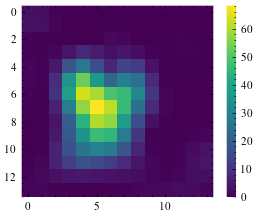

In [373]:
plt.imshow(tf.nn.conv2d(filters=filters[:,:,topW[channels_above, F], F], input= f2.numpy()[:,:,:,topW[channels_above, F]][...,0], strides=1, padding='SAME')[0,...,0])
plt.colorbar()

In [400]:
channels_bellow

array([[0],
       [3],
       [5]], dtype=int64)

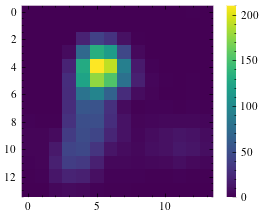

In [374]:
plt.imshow(tf.nn.conv2d(filters=filters[:,:,topW[channels_bellow, F], F], input= f2.numpy()[:,:,:,topW[channels_bellow, F]][...,0], strides=1, padding='SAME')[0,...,0])
plt.colorbar()

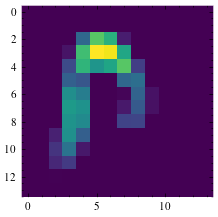

In [375]:
plt.imshow(f1[0,:,:,F])

Try rotating filters 180


In [394]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3) or l.kernel_size == (7,7):
			conv_layers.append(l)
def rotate (model_original, layers)  :
	model = tf.keras.models.clone_model(model_original)
	model.set_weights(model_original.get_weights())
	conv_layers = []
	for l in model.layers:
		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3) or l.kernel_size == (7,7):
				conv_layers.append(l)
	for l in layers:
		filters, biases = conv_layers[l].get_weights()
		print(conv_layers[l].name)
		# Reshape weights to (64 * 128, 3, 3) for batch processing
		k = filters.shape[0]
		weights_reshaped = tf.reshape(filters, (k, k,-1))

		rotated_weights = tf.image.rot90(weights_reshaped, k=2)
		rotated_weights = tf.reshape(rotated_weights, (k, k,filters.shape[-2],filters.shape[-1]))
		
		conv_layers[l].set_weights([rotated_weights, biases])


	return model

model_rot = rotate(model, [-1])
model_rot.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),            
			metrics=[
				keras.metrics.CategoricalAccuracy(name="accuracy"),
				keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),])

_, biases = conv_layers[l_num].get_weights()
filtersR= get_filter(model_rot, l_num)


block5_conv3


In [402]:
channels_above

array([[1],
       [4],
       [6]], dtype=int64)

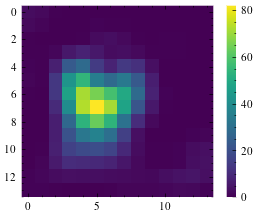

In [395]:
plt.imshow(tf.nn.conv2d(filters=filtersR[:,:,topW[channels_above, F], F], input= f2.numpy()[:,:,:,topW[channels_above, F]][...,0], strides=1, padding='SAME')[0,...,0])
plt.colorbar()

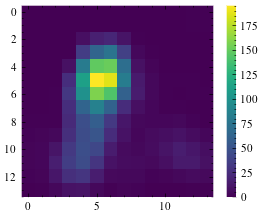

In [396]:
plt.imshow(tf.nn.conv2d(filters=filtersR[:,:,topW[channels_bellow, F], F], input= f2.numpy()[:,:,:,topW[channels_bellow, F]][...,0], strides=1, padding='SAME')[0,...,0])
plt.colorbar()

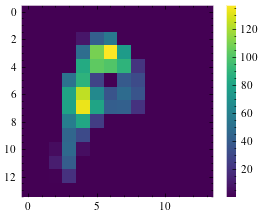

In [397]:
plt.imshow(tf.nn.relu(tf.nn.conv2d(filters=filtersR, input= f2, strides=1, padding='SAME')[0,...,F])+ biases[F])
plt.colorbar()

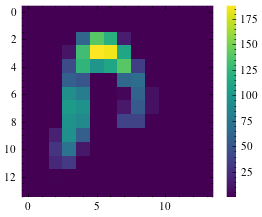

In [398]:
plt.imshow(tf.nn.relu(tf.nn.conv2d(filters=filters, input= f2, strides=1, padding='SAME')[0,...,F]) + biases[F])
plt.colorbar()

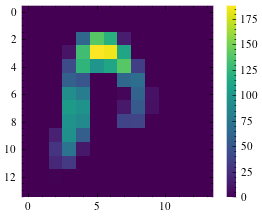

In [399]:
plt.imshow(f1[0,:,:,F])
plt.colorbar()

In [409]:
topW[channels_above, F][0,0]

384

(3, 3, 512, 512)
(512,)


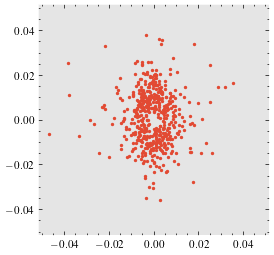

In [447]:
Fp = topW[channels_above, F][2,0]
filters = get_filter(model, l_num-1)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,Fp]*np.cos((theta[:,Fp]))).numpy()
y = (a_mag[:,Fp]*np.sin((theta[:,Fp]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))

domOrr = getDominantAngle(filters[...,[Fp]])[0]


ax.scatter(x,y, s=2, color="#E24A33")
        


ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)


ax.annotate("", xy=(np.cos(domOrr), np.sin(domOrr)), xytext=(0, 0), 
                    arrowprops=dict(arrowstyle="->",  color='black', lw=None))
plt.show()

In [442]:
np.cos(domOrr), np.sin(domOrr)

(-0.045408886, 0.9989685)

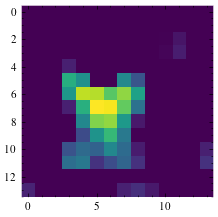

In [443]:
plt.imshow(f2[0,:,:,Fp])
